# Pyke data analysis

## Gathering data

All games with Pyke, including timeline data, is in the collection "game_pyke_timeline".

In [1]:
import pymongo

client = pymongo.MongoClient()
db = client.pyke_2020
mongoTable = db["game_pyke_timeline"]

Functions to get all participants perks and all the items to got in the game (not only end of game items).

In [2]:
def get_participant_perks(p):
    perks = []
    for s in ["perk0","perk1","perk2","perk3","perk4"]:
        perks.append(p["stats"][s])
    return perks

def get_timeline_items(timeline):
    
    participant_items = {i:[] for i in range(1,11)}
    
    for frame in timeline["frames"]:
        for event in frame["events"]:
            if event["type"] == "ITEM_PURCHASED":
                participant_items[event["participantId"]].append(event["itemId"])
    return participant_items

Static data to get specific perks and item ID.

In [3]:
aftershock = 8439
manaflow = 8226
catalyst = 3010


queue_types = {
    400:"Normal",
    420:"Ranked",
    430:"Normal",
    440:"Ranked",
    450:"Normal",
    840:"Coop vs IA",
    850:"Coop vs IA"
}

Gather all the interesting data from raw data in the Mongo collection

In [4]:
stats_pyke = []

for g in mongoTable.find():
    
    items = get_timeline_items(g["timeline"])
    
    pId_to_accId = {}
    for p in g["participantIdentities"]:
        pId_to_accId[p["participantId"]] = p["player"]["currentAccountId"]
    
    for p in g["participants"]:
    
        # Only get Pyke players
        if p["championId"] == 555:
            row = {}

            row["gameId"] = g["gameId"]
            row["queueId"] = g["queueId"]
            row["queueType"] = queue_types[g["queueId"]] if g["queueId"] in queue_types.keys() else "Others"
            row["timestamp"] = g["gameCreation"]
            row["gameDuration"] = g["gameDuration"]
            row["player"] = pId_to_accId[p["participantId"]]
            row["has_aftershock_manaflow"] = aftershock in get_participant_perks(p) and manaflow in get_participant_perks(p)
            row["has_catalyst"] = catalyst in  items[p["participantId"]]
            row["healing"] = p["stats"]["totalHeal"]
            row["win"] = p["stats"]["win"]

            stats_pyke.append(row)

## Analyzing data

Fitting everything in a DataFrame.

In [5]:
import pandas as pd
df_build = pd.DataFrame(stats_pyke)

### Games distribution

Finding the number of times where Aftershock and Manaflow Band were picked with a Catalyst by a Pyke : 

In [6]:
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]))].shape[0]

683

Finding the number of players who used this build : 

In [7]:
len(df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]))]["player"].unique())

586

Break down the number of games with that build by queue

In [8]:
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("queueType").count()["gameId"]

queueType
Coop vs IA     15
Normal        502
Ranked        166
Name: gameId, dtype: int64

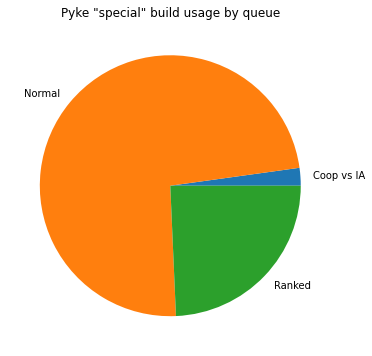

In [9]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(facecolor="w")

df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("queueType").count()["gameId"].plot.pie(ax=ax, figsize=(6,6))
ax.set_title('Pyke "special" build usage by queue')
ax.set_ylabel("")
ax.set_xlabel("")
plt.show()

### Games by player

How many times a player used this build : 

In [10]:
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("player").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index()

1     526
2      41
3      12
4       3
5       1
6       2
10      1
Name: gameId, dtype: int64

How many times a player used this build in ranked : 

In [11]:
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) & (df_build["queueType"] == "Ranked"))].groupby("player").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index()

1    139
2      9
3      3
Name: gameId, dtype: int64

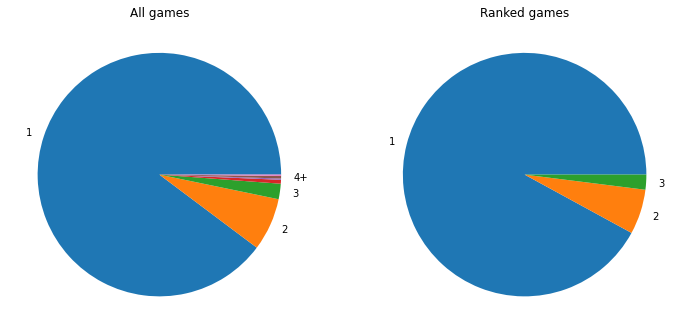

In [12]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1,2,facecolor="w")

df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("player").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index().plot.pie(ax=axs[0], figsize=(6,6), labels=[1,2,3,"","","4+","",""])
axs[0].set_title('All games')
axs[0].set_ylabel("")
axs[0].set_xlabel("")


df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) & (df_build["queueType"] == "Ranked"))].groupby("player").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index().plot.pie(ax=axs[1], figsize=(6,6))
axs[1].set_title('Ranked games')
axs[1].set_ylabel("")
axs[1].set_xlabel("")

fig.set_size_inches(12,6)


plt.show()


Figure : Number of games with Pyke "special" build per player

In [13]:
df_games_per_player = pd.DataFrame(
    [
        df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("player").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index(), 
        df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) & (df_build["queueType"] == "Ranked") )].groupby("player").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index()
    ], 
    index=["All", "Ranked"]
) \
.fillna(0) \
.astype(int).T

df_games_per_player

,All,Ranked
1,526,139
2,41,9
3,12,3
4,3,0
5,1,0
6,2,0
10,1,0


In [14]:
from tabulate import tabulate
print(tabulate(df_games_per_player, tablefmt="pipe", headers="keys"))

|    |   All |   Ranked |
|---:|------:|---------:|
|  1 |   526 |      139 |
|  2 |    41 |        9 |
|  3 |    12 |        3 |
|  4 |     3 |        0 |
|  5 |     1 |        0 |
|  6 |     2 |        0 |
| 10 |     1 |        0 |


### Winrate

Winrate by queue : 

In [15]:
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("queueType")["win"].mean()

queueType
Coop vs IA    1.000000
Normal        0.442231
Ranked        0.403614
Name: win, dtype: float64

Pyke winrate by queue : 

In [16]:
df_build.groupby("queueType")["win"].mean()

queueType
Coop vs IA    0.987303
Normal        0.477577
Others        0.386518
Ranked        0.488687
Name: win, dtype: float64

In [17]:
df_build.groupby("queueType")["win"].mean().drop("Others")

queueType
Coop vs IA    0.987303
Normal        0.477577
Ranked        0.488687
Name: win, dtype: float64

In [18]:
df_winrate = pd.DataFrame(
    [
        df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("queueType")["win"].mean(),
        df_build.groupby("queueType")["win"].mean().drop("Others")
    ], index=["Special build", "All Pyke"]).T
df_winrate

,Special build,All Pyke
queueType,,
Coop vs IA,1.000000,0.987303
Normal,0.442231,0.477577
Ranked,0.403614,0.488687


In [19]:
print(tabulate(df_winrate, tablefmt="pipe", headers="keys"))

| queueType   |   Special build |   All Pyke |
|:------------|----------------:|-----------:|
| Coop vs IA  |        1        |   0.987303 |
| Normal      |        0.442231 |   0.477577 |
| Ranked      |        0.403614 |   0.488687 |


Focusing on ranked players experience with Pyke

In [20]:
mongo_matchlist = db["matchlists_2"]
games_with_pykes_per_player = {}

# Taking all players having played the Special build on Pyke in ranked
for i in df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) & ((df_build["queueId"] == 420) | (df_build["queueId"] == 440)))]["player"].unique():
    
    for m in mongo_matchlist.find({"accountId":i}).limit(1):
        
        # Finding their matches
        matches = [i["matchId"] for i in m["matchlist"]]
        games_with_pyke = 0
        
        # Looking at these specific games
        for g in mongoTable.find({"gameId":{"$in":matches}},{"gameId":1,"participants.championId":1,"participants.participantId":1,"participantIdentities.participantId":1,"participantIdentities.player.currentAccountId":1}):
            
            participantId = [p["participantId"] for p in g["participantIdentities"] if p["player"]["currentAccountId"] == i][0]
            championId = [p["championId"] for p in g["participants"] if p["participantId"] == participantId][0]
            
            # Checking if the player played Pyke
            games_with_pyke += 1 if championId == 555 else 0
        
        games_with_pykes_per_player[i] = games_with_pyke

In [21]:
experimented_series = pd.Series(games_with_pykes_per_player)
experimented_series.describe()

count    151.000000
mean       6.549669
std       10.422213
min        0.000000
25%        1.000000
50%        3.000000
75%        7.000000
max       68.000000
dtype: float64

In [22]:
experimented_pyke_players = [i for i in games_with_pykes_per_player if games_with_pykes_per_player[i] >=10]

In [23]:
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) & (df_build["player"].isin(experimented_pyke_players)) & ((df_build["queueId"] == 420) | (df_build["queueId"] == 440)))]["win"].describe()

count       28
unique       2
top       True
freq        14
Name: win, dtype: object

### Healing distribution

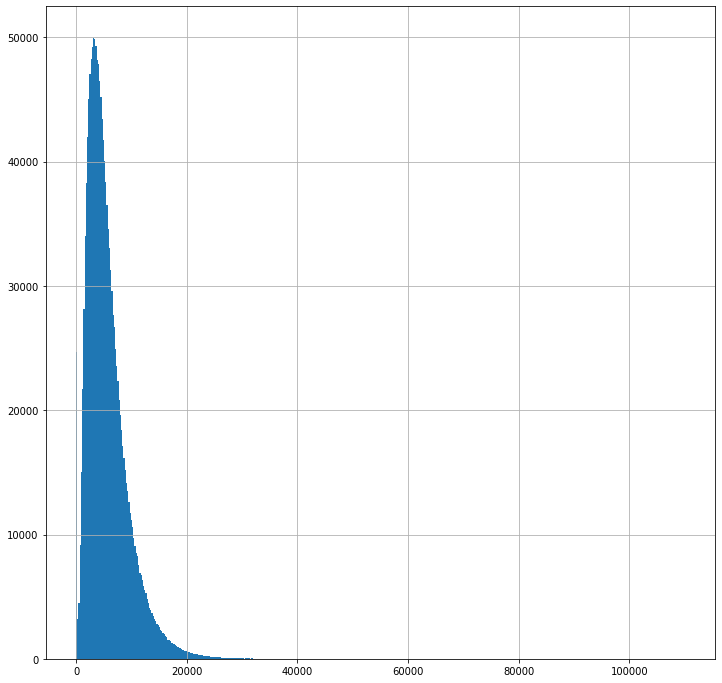

In [24]:
df_build["healing"].hist(bins=500, range=(0, 110000), figsize=(12,12))

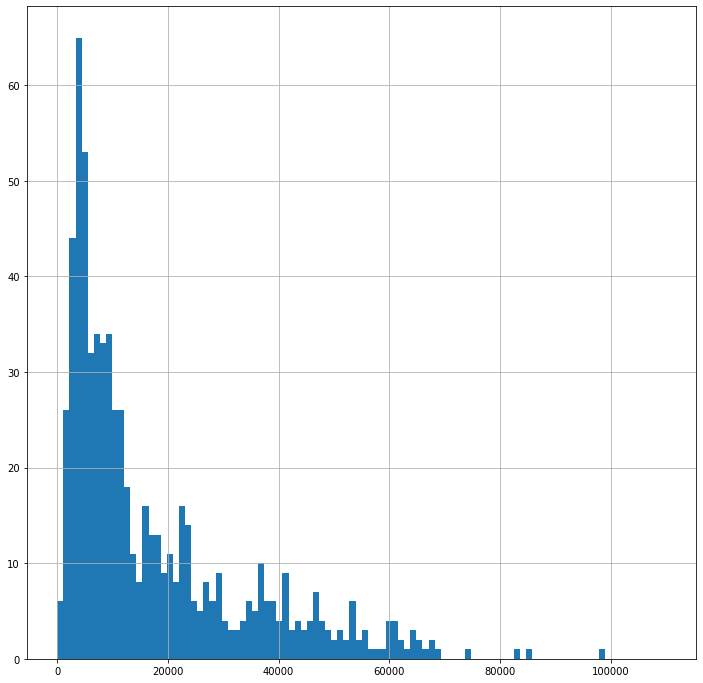

In [25]:
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]))]["healing"].hist(bins=100, range=(0, 110000), figsize=(12,12))

Text(0.5, 0, 'Healing done')

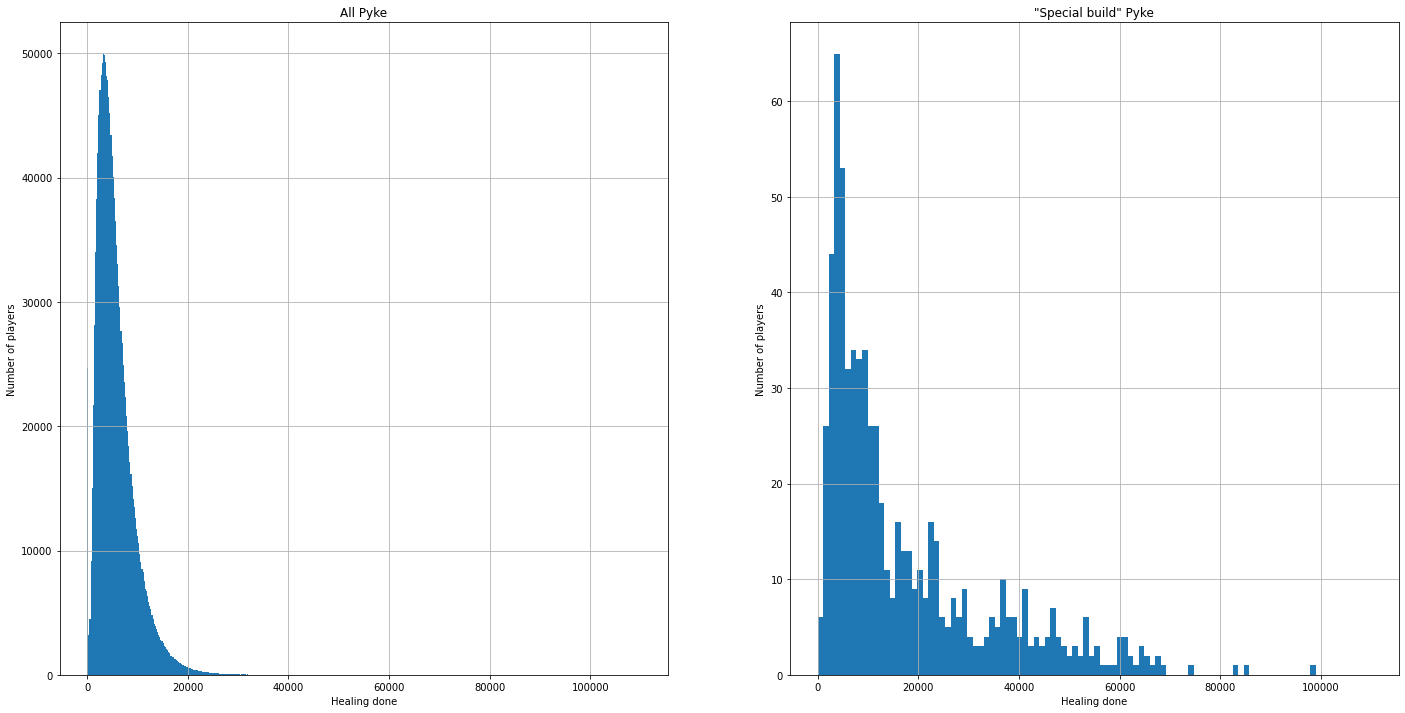

In [26]:
fig, axs = plt.subplots(1,2,facecolor="w")

df_build["healing"].hist(bins=500, range=(0, 110000), figsize=(12,12), ax = axs[0])
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]))]["healing"].hist(bins=100, range=(0, 110000), figsize=(12,12), ax = axs[1])
fig.set_size_inches(24,12)

axs[0].set_title('All Pyke')
axs[0].set_ylabel("Number of players")
axs[0].set_xlabel("Healing done")

axs[1].set_title('"Special build" Pyke')
axs[1].set_ylabel("Number of players")
axs[1].set_xlabel("Healing done")

Figure : Distribution of healing done per Pyke

### Healing per day

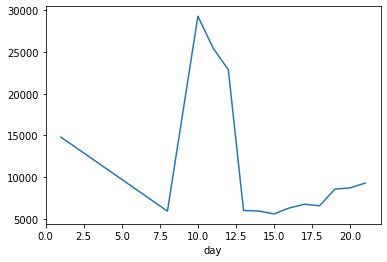

In [27]:
df_build["normalized_timestamp"] = ((df_build["timestamp"] - 1587543600000) / 1000).astype(int)
df_build["day"] = (df_build["normalized_timestamp"]/(24*3600)).astype(int)
df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )].groupby("day").mean()["healing"].plot()

### Merging data about healing and games played per day

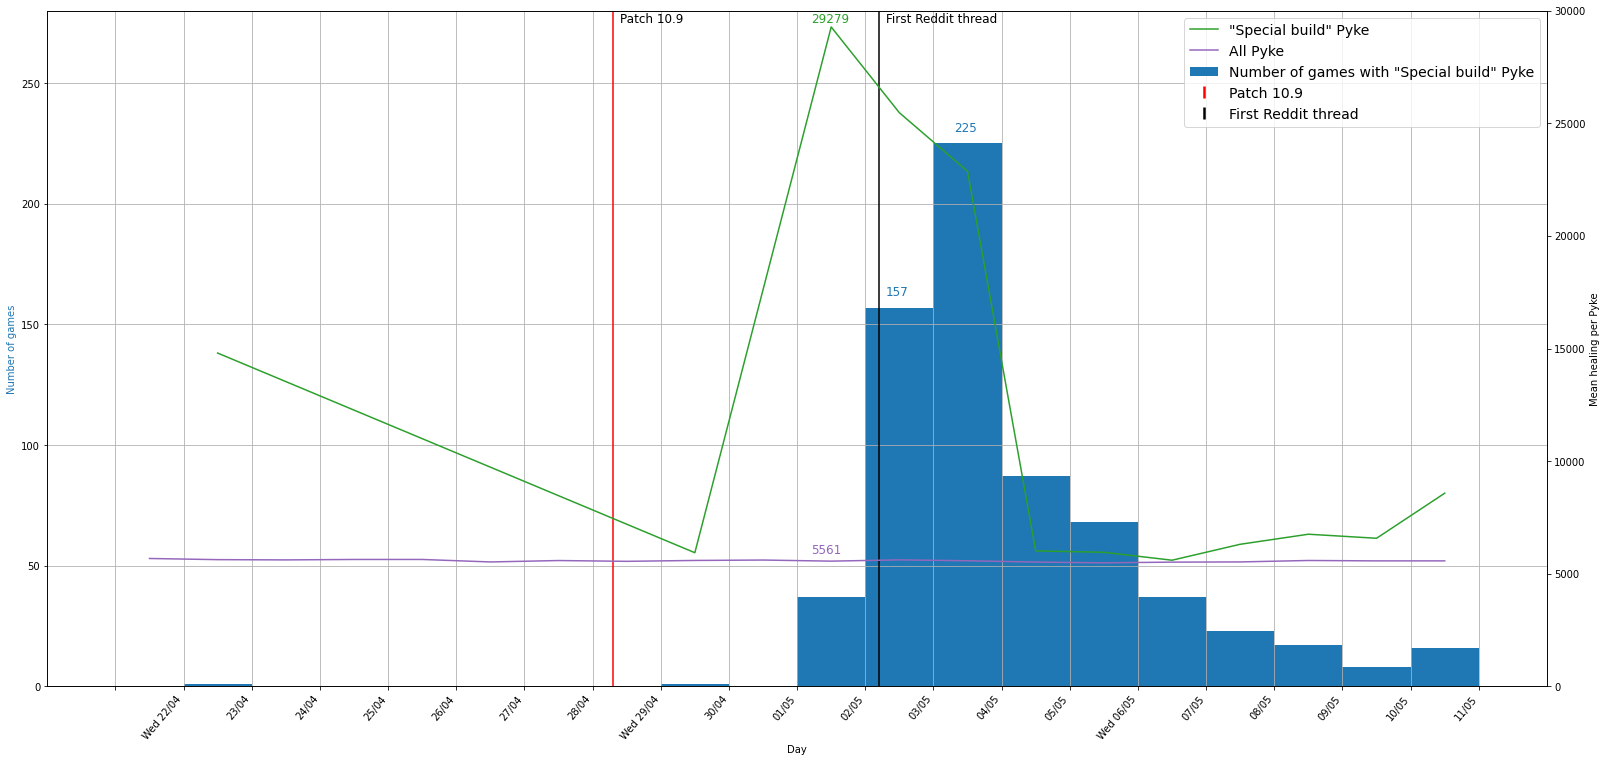

In [28]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(facecolor="w")

df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"]) )]["day"].hist(bins=20, figsize=(12,6), xrot=50, range=(0,20), ax=ax)
ax.axvline(x=7.3, color="red")
ax.axvline(x=11.2, color="black")
ax.text(7.3+0.1, 275, "Patch 10.9", fontsize=12)
ax.text(11.2+0.1, 275, "First Reddit thread", fontsize=12)
ax.set_ylim(0,280)
ax.set_ylabel("Number of games", color="tab:blue")
ax.set_xlabel("Day")
#ax.set_title('Number of games with "Special build" Pyke per day')


ax2 = ax.twinx()

color = 'tab:green'
color2 = 'tab:purple'
ax2.set_ylabel('Mean healing per Pyke') 
series_healing = df_build[((df_build["has_catalyst"]) & (df_build["has_aftershock_manaflow"])  & (df_build["day"] < 20) )].groupby("day").mean()["healing"]
ax2.plot(series_healing.index+0.5, series_healing.values, color="tab:green", label='"Special build" Pyke')
series_healing = df_build[((df_build["day"] < 20) )].groupby("day").mean()["healing"]
ax2.plot(series_healing.index+0.5, series_healing.values, color=color2, label="All Pyke")
ax2.tick_params(axis='y')
ax2.set_ylim((0,30000))

ax.text(10.1+0.1, 275, "29279", fontsize=12, color="#2ca02c")
ax.text(10.1+0.1, 55, "5561", fontsize=12, color="#9467bd")

ax.text(12.2+0.1, 230, "225", fontsize=12, color="#1f77b4")
ax.text(11.2+0.1, 162, "157", fontsize=12, color="#1f77b4")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#2ca02c', label='"Special build" Pyke'),
                   Line2D([0], [0], color='#9467bd', label='All Pyke'),
                   Patch(facecolor='#1f77b4', label='Number of games with "Special build" Pyke'),
                   Line2D([0], [0], color='red', marker='|', linestyle='None',
                          markersize=12, markeredgewidth=2.5, label='Patch 10.9'),
                   Line2D([0], [0], color='black', marker='|', linestyle='None',
                          markersize=12, markeredgewidth=2.5, label='First Reddit thread'),
                  ]



ax2.legend(handles=legend_elements, fontsize=14)

ax.set_xticks([i for i in range(0,21)], minor=False)
ax.set_xticklabels(["","Wed 22/04","23/04","24/04","25/04","26/04","27/04","28/04",
                    "Wed 29/04","30/04","01/05","02/05","03/05","04/05","05/05",
                    "Wed 06/05","07/05","08/05","09/05","10/05","11/05","12/05"], ha="right")

fig.tight_layout()
fig.set_size_inches(24,12)

plt.show()